In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'
%load_ext line_profiler
%load_ext memory_profiler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")
np.random.seed(0)

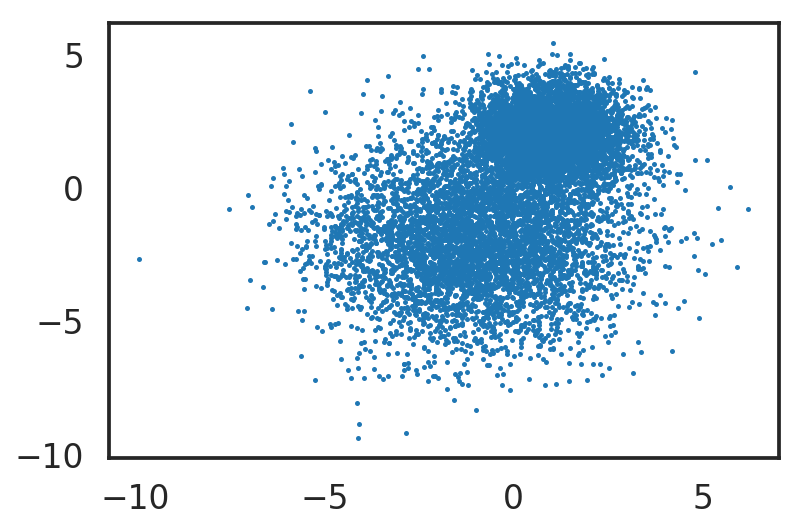

In [3]:
from sklearn.datasets import make_blobs
centers = np.asarray([[1., 2.],
                      [-1., -2.]])
blob, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=[1, 2])
eval_points = np.linspace(-10, 10)
grid = np.meshgrid(eval_points, eval_points)
x_grid, y_grid = grid
grid = np.stack([g.flat for g in grid], axis=1)
b = np.ones((2,), dtype=np.float64)

plt.scatter(blob[:, 0], blob[:, 1], s=1)

## Naive Product KDE


+ $\frac{1}{N}\sum_{i=1}^{N} K(x, x^{i}, h_{1}, ..., h_{d})$
+ where $K(x, x^{i}, h_{1}, ..., h_{d}) = \frac{1}{h_{1}, ..., h_{d}} \prod_{d=1}^{D} K_{d}\big( \frac{x_{d} - x_{d}^{i}}{h_{d}} \big)$

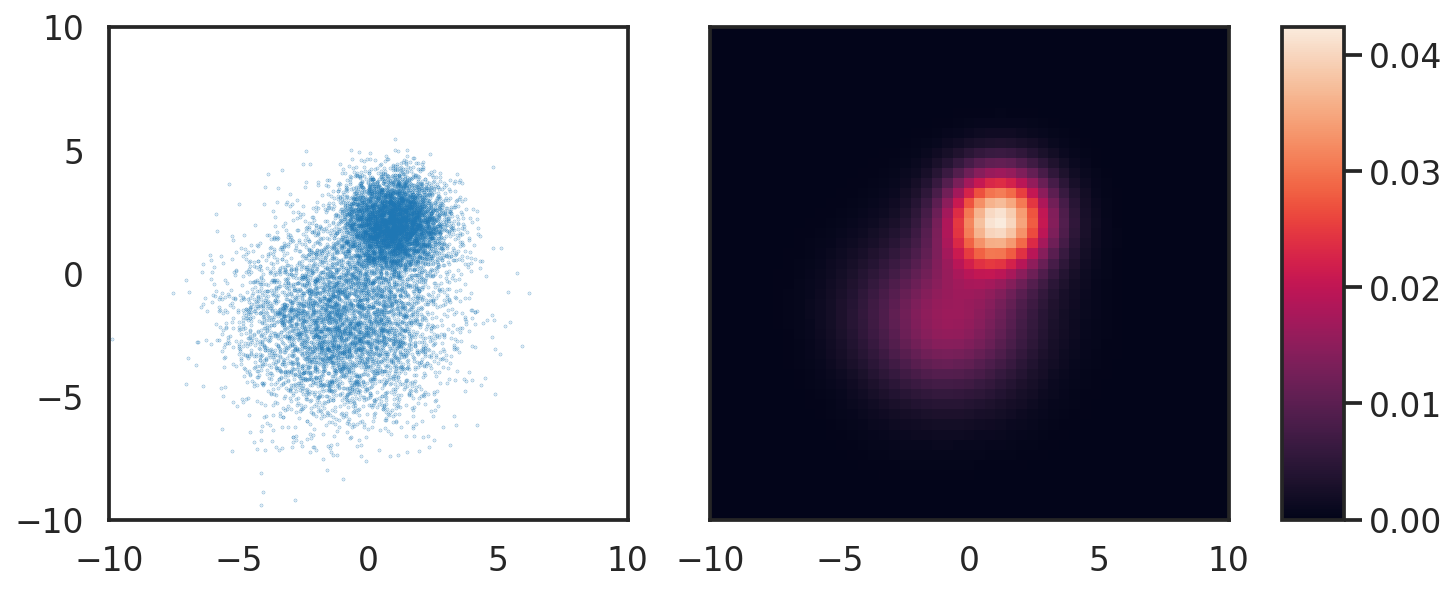

In [5]:
import numba


@numba.jit(nopython=True)
def gaussian(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)


def numpy_kde(eval_points, samples, bandwidths):
    # This uses a lot of RAM and doesn't scale to larger datasets
    return np.mean(
        np.prod(
            gaussian(((eval_points[np.newaxis, ...] - samples[:, np.newaxis, ...]) / bandwidths)),
        axis=-1),
        axis=0) / np.prod(bandwidths)


result = numpy_kde(grid, blob, b)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,
                         figsize=(10, 4), constrained_layout=True)
axes[0].scatter(blob[:, 0], blob[:, 1], s=0.1, alpha=0.5)
mappable = axes[1].pcolormesh(x_grid, y_grid, result.reshape(50, 50));
plt.colorbar(mappable, ax=axes[1])

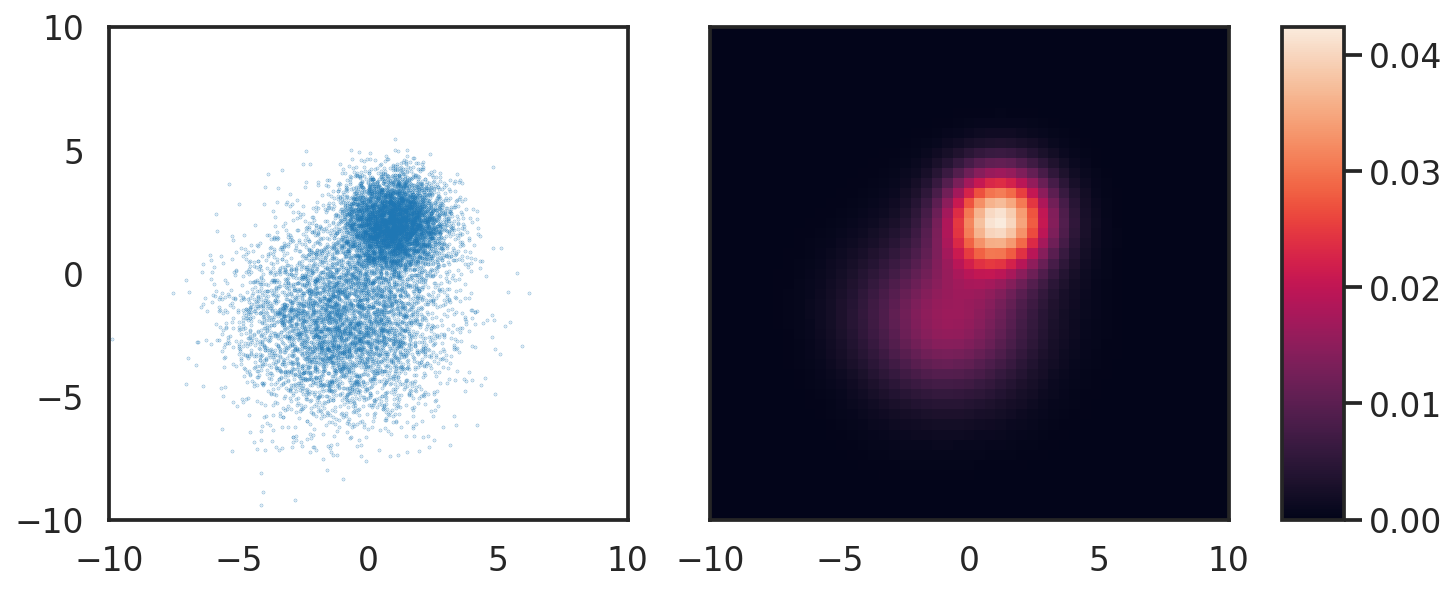

In [8]:
import dask.array as da

def dask_gaussian(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)

def dask_kde(eval_points, samples, bandwidths, chunks_eval=None, chunks_samples=None):
    if chunks_eval is None:
        chunks_eval = ('auto', -1)
    if chunks_samples is None:
        chunks_samples = ('auto', -1)
    rescaled_x = (da.from_array(eval_points, chunks_eval)[np.newaxis, ...] -
                  da.from_array(samples, chunks_samples)[:, np.newaxis, ...]) / bandwidths
    return (da.mean(da.prod(dask_gaussian(rescaled_x), axis=-1), axis=0) / da.prod(bandwidths)).compute()


result = dask_kde(grid, blob, b, chunks_samples=('auto', -1))

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,
                         figsize=(10, 4), constrained_layout=True)
axes[0].scatter(blob[:, 0], blob[:, 1], s=0.1, alpha=0.5)
mappable = axes[1].pcolormesh(x_grid, y_grid, result.reshape(50, 50));
plt.colorbar(mappable, ax=axes[1])

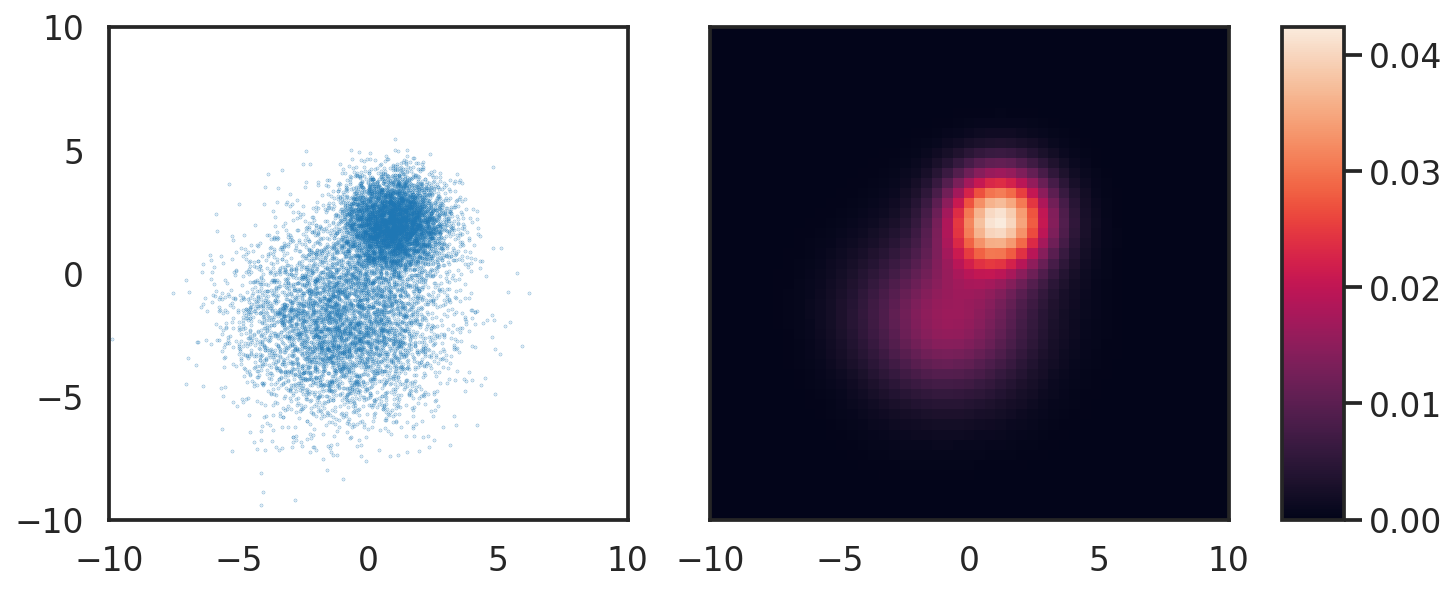

In [9]:
from sklearn.neighbors import KernelDensity

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x)
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid)
    return np.exp(log_pdf)


result = kde_sklearn(blob, grid, bandwidth=1.0)
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,
                         figsize=(10, 4), constrained_layout=True)
axes[0].scatter(blob[:, 0], blob[:, 1], s=0.1, alpha=0.5)
mappable = axes[1].pcolormesh(x_grid, y_grid, result.reshape(50, 50));
plt.colorbar(mappable, ax=axes[1])

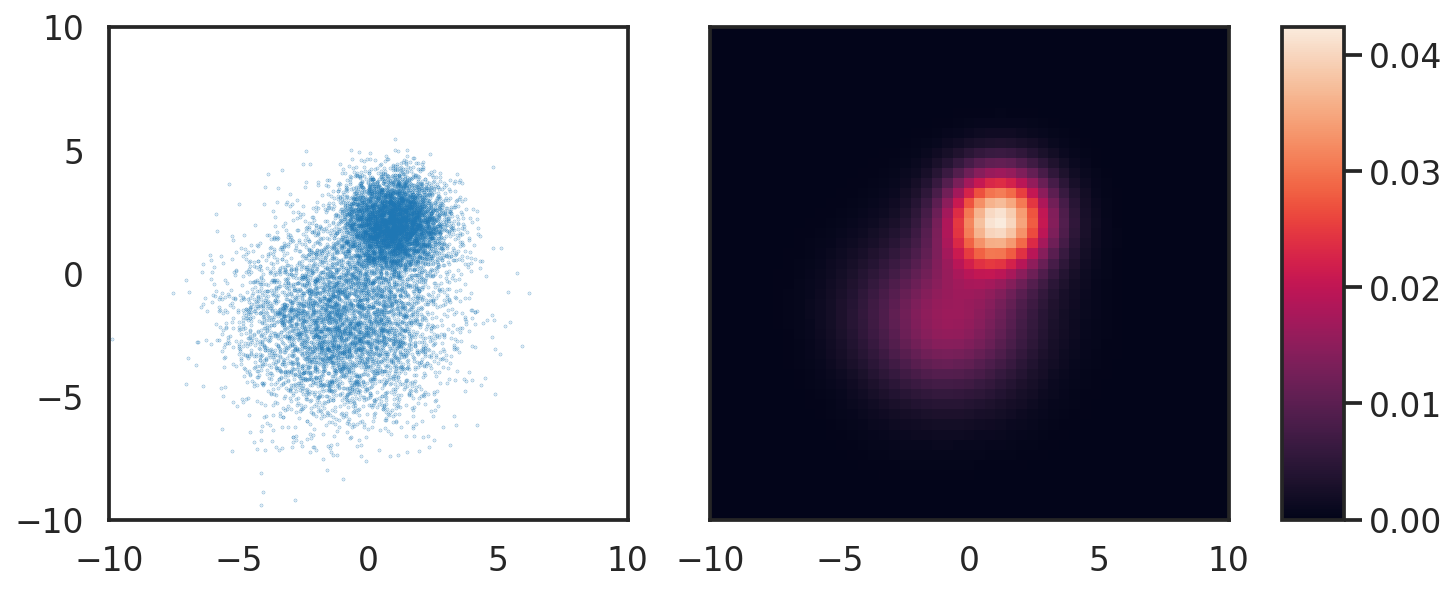

In [10]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate


def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    n_dim = x.shape[1]
    kde = KDEMultivariate(x, bw=bandwidth,
                          var_type='c' * n_dim, **kwargs)
    return kde.pdf(x_grid)

result = kde_statsmodels_m(blob, grid, bandwidth=b)
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,
                         figsize=(10, 4), constrained_layout=True)
axes[0].scatter(blob[:, 0], blob[:, 1], s=0.1, alpha=0.5)
mappable = axes[1].pcolormesh(x_grid, y_grid, result.reshape(50, 50));
plt.colorbar(mappable, ax=axes[1])

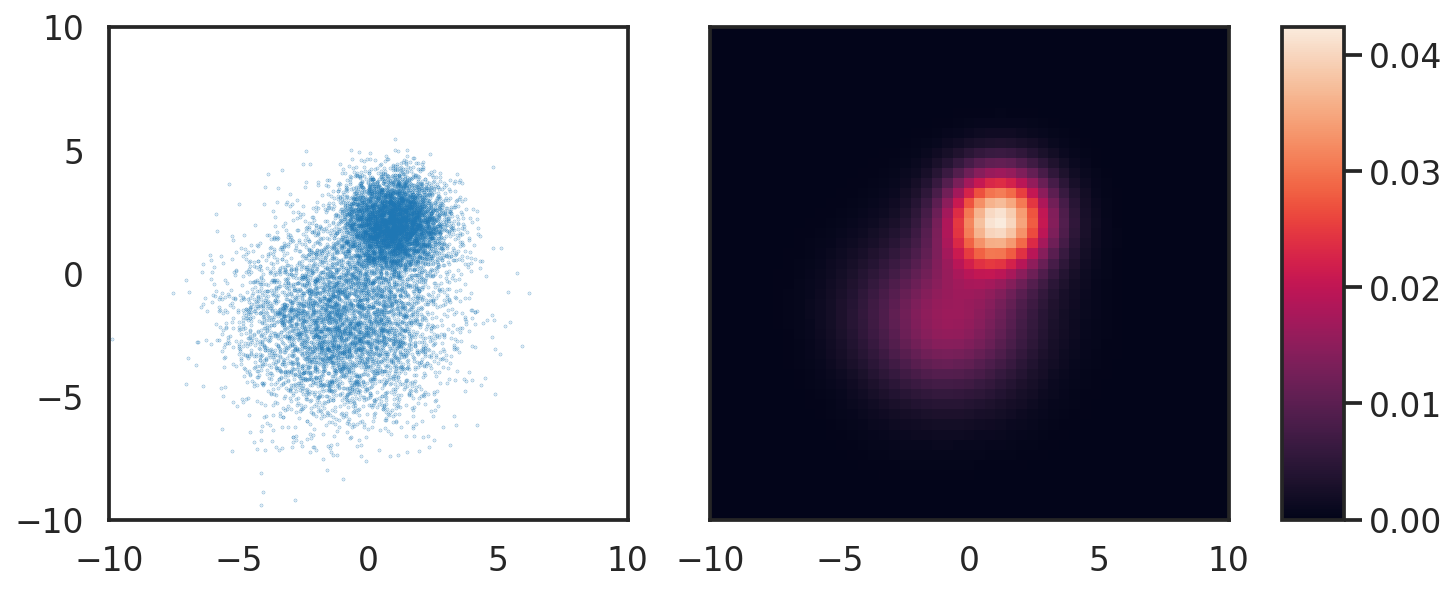

In [11]:
import numba

@numba.jit(nopython=True)
def gaussian(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)


@numba.jit(nopython=True)
def numba_kde(eval_points, samples, bandwidths):
    n_eval_points = len(eval_points)
    result = np.zeros((n_eval_points,))
    n_samples = len(samples)
    denom = n_samples * np.prod(bandwidths)

    for i in range(n_eval_points):
        for j in range(n_samples):
            result[i] += np.prod(gaussian((eval_points[i] - samples[j]) / bandwidths))
        result[i] /= denom

    return result


result = numba_kde(grid, blob, b)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,
                         figsize=(10, 4), constrained_layout=True)
axes[0].scatter(blob[:, 0], blob[:, 1], s=0.1, alpha=0.5)
mappable = axes[1].pcolormesh(x_grid, y_grid, result.reshape(50, 50));
plt.colorbar(mappable, ax=axes[1])

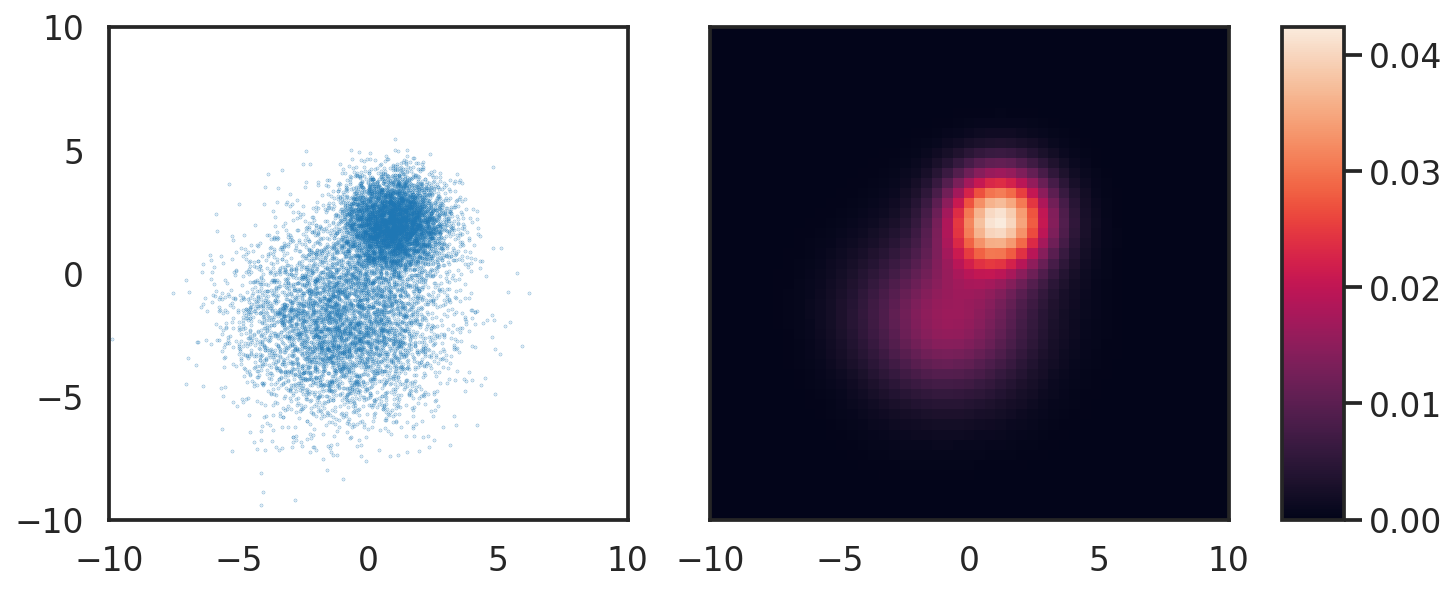

In [12]:
import numba

@numba.jit(nopython=True)
def gaussian(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)


@numba.jit(nopython=True, parallel=True, fastmath=True)
def numba_kde_multithread(eval_points, samples, bandwidths):
    n_eval_points = len(eval_points)
    result = np.zeros((n_eval_points,))
    n_samples = len(samples)
    denom = n_samples * np.prod(bandwidths)

    for i in numba.prange(n_eval_points):
        for j in range(n_samples):
            result[i] += np.prod(gaussian((eval_points[i] - samples[j]) / bandwidths))
        result[i] /= denom

    return result


result = numba_kde_multithread(grid, blob, b)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,
                         figsize=(10, 4), constrained_layout=True)
axes[0].scatter(blob[:, 0], blob[:, 1], s=0.1, alpha=0.5)
mappable = axes[1].pcolormesh(x_grid, y_grid, result.reshape(50, 50));
plt.colorbar(mappable, ax=axes[1])

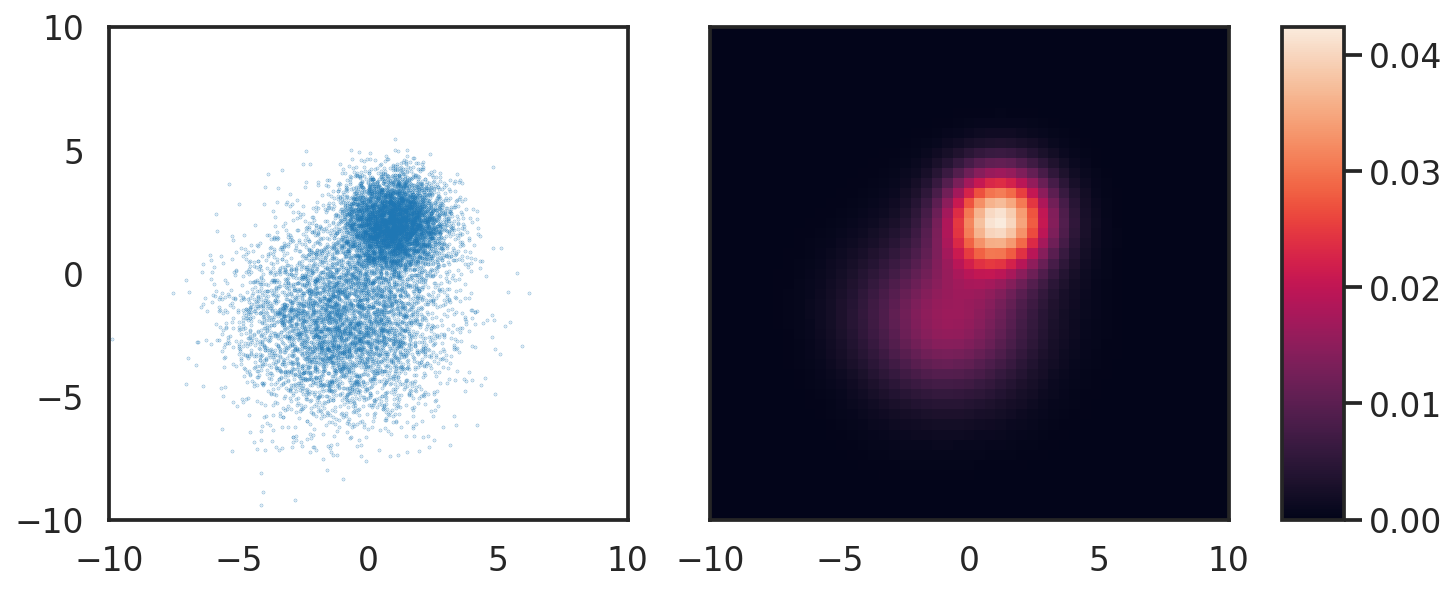

In [13]:
import numba

import math

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))

# @vectorize(['float32(float32, float32, float32)'], target='cuda')
# def gaussian_pdf(x, mean, sigma):
#     '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
#     return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

@numba.vectorize(['float64(float64, float64, float64)'], nopython=True)
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@numba.njit('float64[:](float64[:, :], float64[:, :], float64[:])')
def numba_kde2(eval_points, samples, bandwidths):
    n_eval_points = len(eval_points)
    result = np.zeros((n_eval_points,))
    n_samples = len(samples)
    denom = n_samples * np.prod(bandwidths)

    for i in range(n_eval_points):
        for j in range(n_samples):
            result[i] += np.prod(
                gaussian_pdf(eval_points[i], samples[j], bandwidths))
        result[i] /= denom

    return result

result = numba_kde2(grid, blob, b)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,
                         figsize=(10, 4), constrained_layout=True)
axes[0].scatter(blob[:, 0], blob[:, 1], s=0.1, alpha=0.5)
mappable = axes[1].pcolormesh(x_grid, y_grid, result.reshape(50, 50));
plt.colorbar(mappable, ax=axes[1])

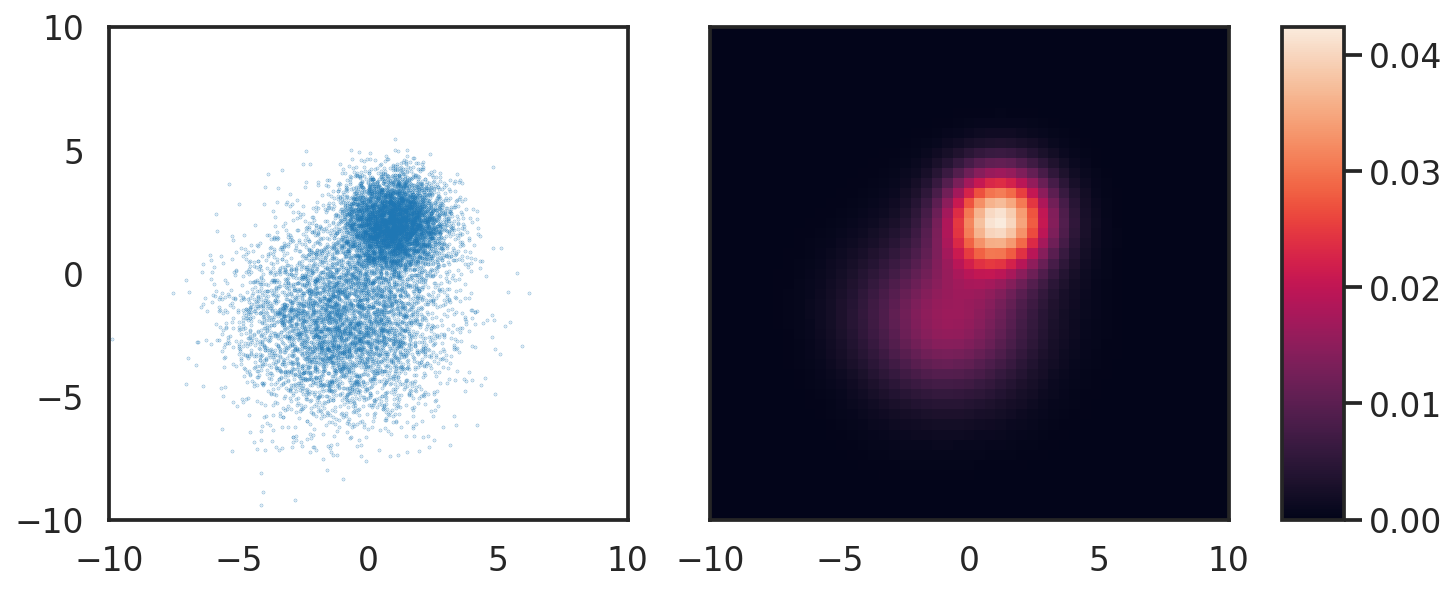

In [14]:
import numba
import math

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))

@numba.vectorize(['float64(float64, float64, float64)'], nopython=True, target='cpu')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@numba.njit('float64[:](float64[:, :], float64[:, :], float64[:])', parallel=True, fastmath=True)
def numba_kde_multithread2(eval_points, samples, bandwidths):
    n_eval_points = len(eval_points)
    result = np.zeros((n_eval_points,))
    n_samples = len(samples)
    denom = n_samples * np.prod(bandwidths)

    for i in numba.prange(n_eval_points):
        for j in range(n_samples):
            result[i] += np.prod(
                gaussian_pdf(eval_points[i], samples[j], bandwidths))
        result[i] /= denom

    return result


result = numba_kde_multithread2(grid, blob, b)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,
                         figsize=(10, 4), constrained_layout=True)
axes[0].scatter(blob[:, 0], blob[:, 1], s=0.1, alpha=0.5)
mappable = axes[1].pcolormesh(x_grid, y_grid, result.reshape(50, 50));
plt.colorbar(mappable, ax=axes[1])

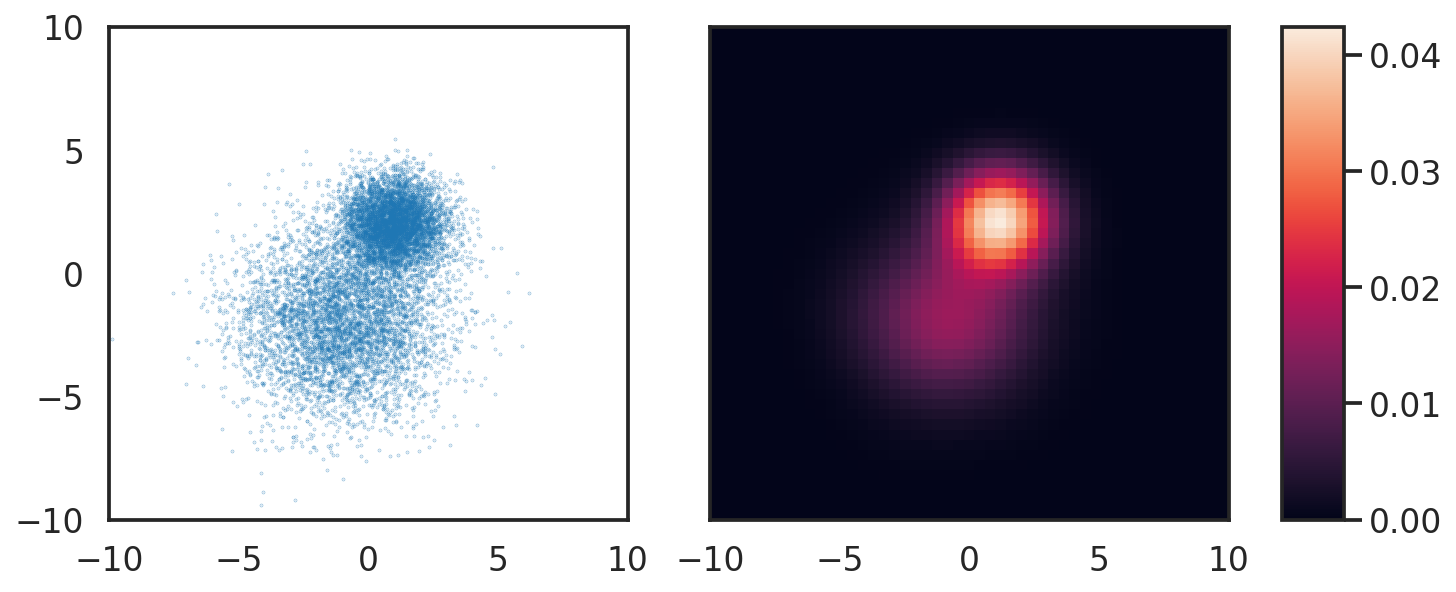

In [16]:
from sklearn.neighbors import KDTree
import numba


@numba.njit
def fast_intersect(array_collection):
    '''
    https://groups.google.com/a/continuum.io/forum/#!topic/numba-users/2oxtyd4_2iQ
    '''
    for idx in range(len(array_collection)):
        arr_set = set(array_collection[idx])
        if idx == 0:
            result = arr_set
        else:
            result = result.intersection(arr_set)

    return np.array(list(result))


@numba.njit(parallel=True, fastmath=True)
def _interior(eval_points, intersect_ind, samples, bandwidths, denom):
    n_eval_points = len(eval_points)
    result = np.zeros((n_eval_points,))

    for i in numba.prange(n_eval_points):
        for j in intersect_ind[i]:
            result[i] += np.prod(
                gaussian_pdf(eval_points[i], samples[j], bandwidths))
        result[i] /= denom
    return result


def numba_kde_prod_tree(eval_points, samples, bandwidths, radius):
    n_samples = len(samples)
    denom = n_samples * np.prod(bandwidths)
    ind = [KDTree(samples[:, [dim]]).query_radius(eval_points[:, [dim]], radius[dim])
           for dim in range(samples.shape[1])]
    intersect_ind = [fast_intersect(sample_inds) for sample_inds in zip(*ind)]

    return _interior(eval_points, intersect_ind, samples, bandwidths, denom)

result = numba_kde_prod_tree(grid, blob, b, b * 4.0)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,
                         figsize=(10, 4), constrained_layout=True)
axes[0].scatter(blob[:, 0], blob[:, 1], s=0.1, alpha=0.5)
mappable = axes[1].pcolormesh(x_grid, y_grid, result.reshape(50, 50));
plt.colorbar(mappable, ax=axes[1])

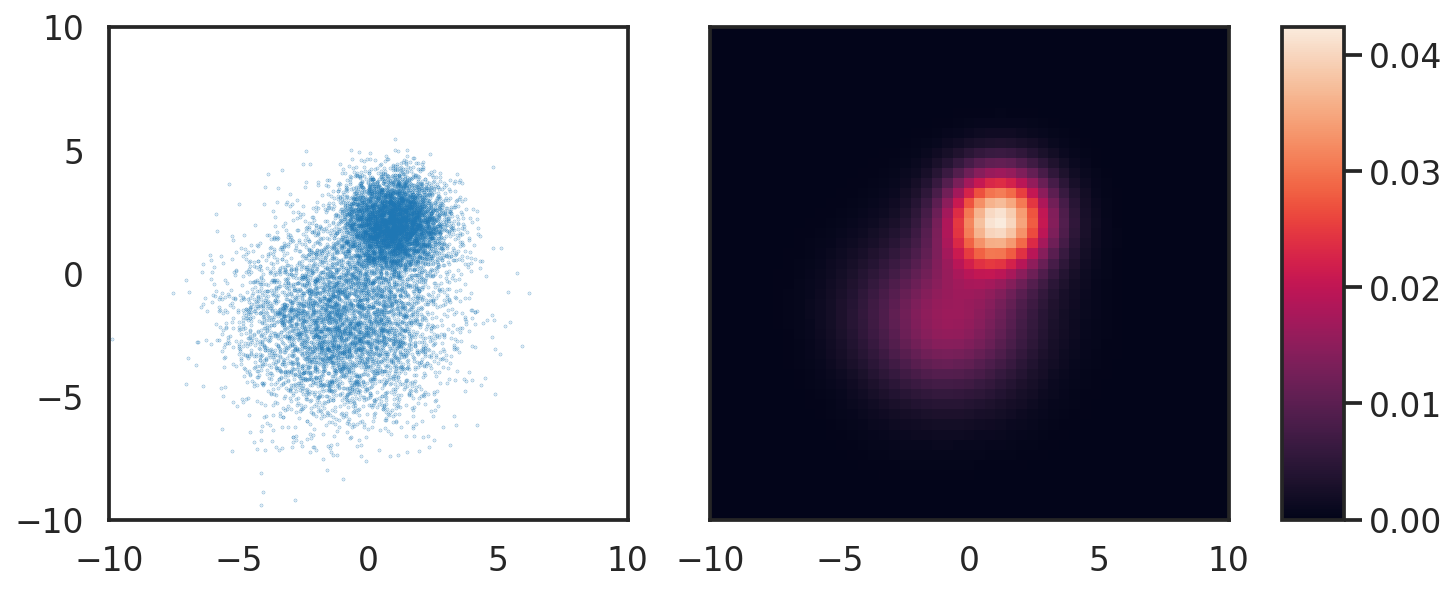

In [18]:
import dask.array as da
import numba
import math

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))

@numba.vectorize(['float64(float64, float64, float64)'], target='cpu')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

def dask_kde2(eval_points, samples, bandwidths, chunks_eval=None, chunks_samples=None):
    if chunks_eval is None:
        chunks_eval = ('auto', -1)
    if chunks_samples is None:
        chunks_samples = ('auto', -1)

    return (da.mean(da.prod(
        gaussian_pdf(da.from_array(eval_points, chunks_eval)[np.newaxis, ...],
                     da.from_array(samples, chunks_samples)[:, np.newaxis, ...],
                     bandwidths), axis=-1), axis=0) / da.prod(bandwidths)).compute()


result = dask_kde2(grid, blob, b, chunks_samples=100)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,
                         figsize=(10, 4), constrained_layout=True)
axes[0].scatter(blob[:, 0], blob[:, 1], s=0.1, alpha=0.5)
mappable = axes[1].pcolormesh(x_grid, y_grid, result.reshape(50, 50));
plt.colorbar(mappable, ax=axes[1])

In [19]:
%%timeit

result = numpy_kde(grid, blob, b)

2.1 s ± 44.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit

result = dask_kde(grid, blob, b)

2.37 s ± 184 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit

result = kde_sklearn(blob, grid, bandwidth=1.0)

958 ms ± 8.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit

result = kde_statsmodels_m(blob, grid, bandwidth=b)

697 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%timeit

result = numba_kde(grid, blob, b)

8.84 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit

result = numba_kde_multithread(grid, blob, b)

6.3 s ± 53.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit

result = numba_kde2(grid, blob, b)

4.41 s ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit

result = numba_kde_multithread2(grid, blob, b)

358 ms ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%timeit

result = numba_kde_prod_tree(grid, blob, b, b * 6.0)

792 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%%timeit

result = dask_kde2(grid, blob, b, chunks_samples=50)

707 ms ± 64.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
np.allclose(numba_kde_prod_tree(grid, blob, b, b * 6.0), kde_sklearn(blob, grid, bandwidth=1.0))

True

In [ ]:
np.allclose(numba_kde_multithread2(grid, blob, b), kde_sklearn(blob, grid, bandwidth=1.0))

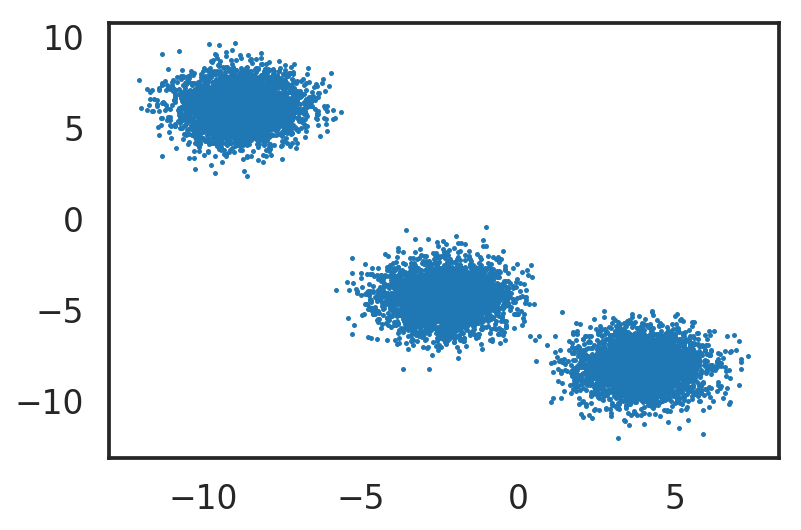

In [29]:
from sklearn.datasets import make_blobs

blob2, _ = make_blobs(n_samples=10000, n_features=6)
grid2 = np.concatenate((grid, np.ones((grid.shape[0], 4))), axis=1)
b2 = np.ones((6,))
plt.scatter(blob2[:, 0], blob2[:, 1], s=1)

In [30]:
%%timeit

result = numpy_kde(grid2, blob2, b2)

4.54 s ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%%timeit

result = dask_kde(grid2, blob2, b2, chunks_samples=50)

1.68 s ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%%timeit

result = kde_sklearn(blob2, grid2, bandwidth=1.0)

409 ms ± 48.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%%timeit

result = kde_statsmodels_m(blob2, grid2, bandwidth=b2)

1.59 s ± 173 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%%timeit

result = numba_kde(grid2, blob2, b2)

9.74 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%%timeit

result = numba_kde_multithread(grid2, blob2, b2)

6.6 s ± 62.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%%timeit

result = numba_kde2(grid2, blob2, b2)

5.49 s ± 47.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%%timeit

result = numba_kde_multithread2(grid2, blob2, b2)

851 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%%timeit

result = numba_kde_prod_tree(grid2, blob2, b2, b2 * 6.0)

1.48 s ± 35.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
%%timeit

result = dask_kde2(grid2, blob2, b2, chunks_samples=50)

1.32 s ± 282 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


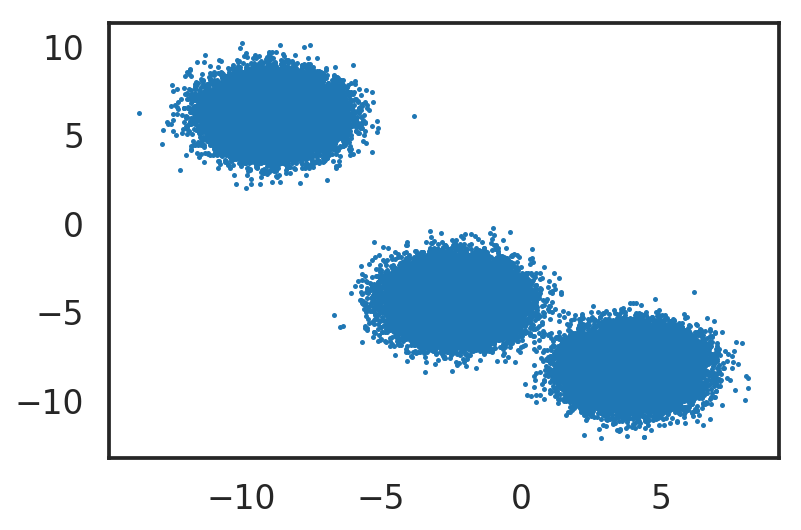

In [19]:
from sklearn.datasets import make_blobs

blob3, _ = make_blobs(n_samples=int(1E5), n_features=6)
grid3 = np.concatenate((grid, np.ones((grid.shape[0], 4))), axis=1)
b3 = np.ones((6,))
plt.scatter(blob3[:, 0], blob3[:, 1], s=1)

In [40]:
%%timeit

result = dask_kde(grid3, blob3, b3, chunks_samples=50)

15 s ± 1.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%%timeit

result = kde_sklearn(blob3, grid3, bandwidth=1.0)

12.7 s ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%%timeit

result = kde_statsmodels_m(blob3, grid3, bandwidth=b3)

16.1 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
%%timeit

result = numba_kde_multithread2(grid3, blob3, b3)

8.52 s ± 162 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%%timeit

result = numba_kde_prod_tree(grid3, blob3, b3, b3 * 6.0)

18.8 s ± 489 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%%timeit

result = numba_kde_prod_tree(grid3, blob3, b3, b3 * 3.0)

7.66 s ± 295 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%%timeit

result = dask_kde2(grid3, blob3, b3, chunks_samples=50)

13.9 s ± 2.92 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%lprun -f numba_kde_prod_tree numba_kde_prod_tree(grid3, blob3, b3, b3 * 6.0)

In [27]:
%memit numba_kde_multithread2(grid3, blob3, b3)

peak memory: 296.80 MiB, increment: 0.00 MiB


In [28]:
%memit kde_sklearn(blob3, grid3, bandwidth=1.0)

peak memory: 297.91 MiB, increment: 1.12 MiB


In [33]:
%memit dask_kde2(grid3, blob3, b3, chunks_samples=50)

peak memory: 342.28 MiB, increment: 41.63 MiB


In [3]:
import math as math

import numba
import numpy as np

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))


@numba.vectorize(['float64(float64, float64, float64)'], nopython=True)
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with
    given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


def product_kde(eval_points, samples, bandwidths):
    result = 0
    n_samples = len(samples)

    for sample_ind in range(n_samples):
        result += np.prod(
            gaussian_pdf(eval_points, samples[sample_ind], bandwidths)
        )

    return result / (n_samples * np.prod(bandwidths))


def get_likelihood(marks, place_bin_centers, bandwidths, occupancy,
                   ground_intensity, training_data, mean_rates):
    '''

    Parameters
    ----------
    marks : ndarray, shape (n_time, n_tetrodes, n_marks)
    place_bin_centers : ndarray, shape (n_bins, n_position_dims)
    bandwidths : ndarray, shape (n_marks + n_position_dims, )
    occupancy : ndarray, shape (n_bins,)
    ground_intensity : ndarray, shape (n_tetrodes, n_bins)
    training_data : list of ndarray, shape (n_samples, n_marks +
                                            n_position_dims)
    mean_rates : ndarray, shape (n_tetrodes,)

    Returns
    -------
    likelihood : ndarray, shape (n_time, n_bins)

    '''
    n_time, n_tetrodes, _ = marks.shape
    n_bins = place_bin_centers.shape[0]
    likelihood = np.ones((n_time, n_bins))

    for time_ind in range(n_time):
        for bin_ind in range(n_bins):
            for tetrode_ind in range(n_tetrodes):
                if ~np.all(np.isnan(marks[time_ind, tetrode_ind])):
                    eval_points = np.concatenate(
                        (marks[time_ind, tetrode_ind],
                         place_bin_centers[bin_ind]))
                    joint_mark_pdf = product_kde(
                        eval_points, training_data[tetrode_ind], bandwidths)
                else:
                    joint_mark_pdf = 1.0

                likelihood[time_ind, bin_ind] *= (
                    (mean_rates[tetrode_ind] * joint_mark_pdf /
                     occupancy[bin_ind]) *
                    math.exp(-ground_intensity[tetrode_ind, bin_ind])
                )
    return likelihood


In [39]:
n_time, n_tetrodes, n_marks = 100, 10, 4
n_bins, n_position_dims = 300, 1
n_samples = 1000

marks = np.ones((n_time, n_tetrodes, n_marks))
marks[1] = np.nan
place_bin_centers = np.ones((n_bins, n_position_dims))
bandwidths = np.ones((n_marks + n_position_dims, ))
occupancy = np.ones((n_bins,))
ground_intensity = np.ones((n_tetrodes, n_bins)) * 0.1
training_data = [np.ones((n_samples, n_marks + n_position_dims))
                 for _ in range(n_tetrodes)]
mean_rates = np.ones((n_tetrodes,))

In [32]:
%lprun -f get_likelihood get_likelihood(marks, place_bin_centers, bandwidths, occupancy, ground_intensity, training_data, mean_rates)

In [34]:
%load_ext snakeviz

In [35]:
%%snakeviz

get_likelihood(marks, place_bin_centers, bandwidths, occupancy,
               ground_intensity, training_data, mean_rates)

 
*** Profile stats marshalled to file '/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/tmpcqn5hclq'. 
Embedding SnakeViz in the notebook...


In [36]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [37]:
%mprun -f get_likelihood get_likelihood(marks, place_bin_centers, bandwidths, occupancy, ground_intensity, training_data, mean_rates)

ERROR: Could not find file <ipython-input-30-ab7ad011e950>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.



In [40]:
import math as math

import numba
import numpy as np

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))


@numba.vectorize(['float64(float64, float64, float64)'], nopython=True)
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with
    given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@numba.njit
def product_kde(eval_points, samples, bandwidths):
    result = 0
    n_samples = len(samples)

    for sample_ind in range(n_samples):
        result += np.prod(
            gaussian_pdf(eval_points, samples[sample_ind], bandwidths)
        )

    return result / (n_samples * np.prod(bandwidths))


@numba.njit
def get_likelihood(marks, place_bin_centers, bandwidths, occupancy,
                   ground_intensity, training_data, mean_rates):
    '''

    Parameters
    ----------
    marks : ndarray, shape (n_time, n_tetrodes, n_marks)
    place_bin_centers : ndarray, shape (n_bins, n_position_dims)
    bandwidths : ndarray, shape (n_marks + n_position_dims, )
    occupancy : ndarray, shape (n_bins,)
    ground_intensity : ndarray, shape (n_tetrodes, n_bins)
    training_data : list of ndarray, shape (n_samples, n_marks +
                                            n_position_dims)
    mean_rates : ndarray, shape (n_tetrodes,)

    Returns
    -------
    likelihood : ndarray, shape (n_time, n_bins)

    '''
    n_time, n_tetrodes, _ = marks.shape
    n_bins = place_bin_centers.shape[0]
    likelihood = np.ones((n_time, n_bins))

    for time_ind in range(n_time):
        for bin_ind in range(n_bins):
            for tetrode_ind in range(n_tetrodes):
                if ~np.all(np.isnan(marks[time_ind, tetrode_ind])):
                    eval_points = np.concatenate(
                        (marks[time_ind, tetrode_ind],
                         place_bin_centers[bin_ind]))
                    joint_mark_pdf = product_kde(
                        eval_points, training_data[tetrode_ind], bandwidths)
                else:
                    joint_mark_pdf = 1.0

                likelihood[time_ind, bin_ind] *= (
                    (mean_rates[tetrode_ind] * joint_mark_pdf /
                     occupancy[bin_ind]) *
                    math.exp(-ground_intensity[tetrode_ind, bin_ind])
                )
    return likelihood


In [41]:
%%timeit

get_likelihood(marks, place_bin_centers, bandwidths, occupancy,
               ground_intensity, training_data, mean_rates)

51 s ± 2.32 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
import math as math

import numba
import numpy as np

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))


@numba.vectorize(['float64(float64, float64, float64)'], nopython=True)
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with
    given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@numba.njit(nogil=True, fastmath=True)
def product_kde(eval_points, samples, bandwidths):
    result = 0
    n_samples = len(samples)

    for sample_ind in range(n_samples):
        result += np.prod(
            gaussian_pdf(eval_points, samples[sample_ind], bandwidths)
        )

    return result / (n_samples * np.prod(bandwidths))


@numba.njit(nogil=True, fastmath=True)
def get_likelihood(marks, place_bin_centers, bandwidths, occupancy,
                   ground_intensity, training_data, mean_rates):
    '''

    Parameters
    ----------
    marks : ndarray, shape (n_time, n_tetrodes, n_marks)
    place_bin_centers : ndarray, shape (n_bins, n_position_dims)
    bandwidths : ndarray, shape (n_marks + n_position_dims, )
    occupancy : ndarray, shape (n_bins,)
    ground_intensity : ndarray, shape (n_tetrodes, n_bins)
    training_data : list of ndarray, shape (n_samples, n_marks +
                                            n_position_dims)
    mean_rates : ndarray, shape (n_tetrodes,)

    Returns
    -------
    likelihood : ndarray, shape (n_time, n_bins)

    '''
    n_time, n_tetrodes, _ = marks.shape
    n_bins = place_bin_centers.shape[0]
    likelihood = np.ones((n_time, n_bins))

    for time_ind in range(n_time):
        for bin_ind in range(n_bins):
            for tetrode_ind in range(n_tetrodes):
                if ~np.all(np.isnan(marks[time_ind, tetrode_ind])):
                    eval_points = np.concatenate(
                        (marks[time_ind, tetrode_ind],
                         place_bin_centers[bin_ind]))
                    joint_mark_pdf = product_kde(
                        eval_points, training_data[tetrode_ind], bandwidths)
                else:
                    joint_mark_pdf = 1.0

                likelihood[time_ind, bin_ind] *= (
                    (mean_rates[tetrode_ind] * joint_mark_pdf /
                     occupancy[bin_ind]) *
                    math.exp(-ground_intensity[tetrode_ind, bin_ind])
                )
    return likelihood


In [43]:
%%timeit

get_likelihood(marks, place_bin_centers, bandwidths, occupancy,
               ground_intensity, training_data, mean_rates)

52 s ± 1.55 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
import math as math

import numba
import numpy as np

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))


@numba.vectorize(['float64(float64, float64, float64)'], nopython=True)
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with
    given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@numba.njit(parallel=True, fastmath=True)
def product_kde(eval_points, samples, bandwidths):
    result = 0
    n_samples = len(samples)

    for sample_ind in range(n_samples):
        result += np.prod(
            gaussian_pdf(eval_points, samples[sample_ind], bandwidths)
        )

    return result / (n_samples * np.prod(bandwidths))


@numba.njit(parallel=True)
def get_likelihood(marks, place_bin_centers, bandwidths, occupancy,
                   ground_intensity, training_data, mean_rates):
    '''

    Parameters
    ----------
    marks : ndarray, shape (n_time, n_tetrodes, n_marks)
    place_bin_centers : ndarray, shape (n_bins, n_position_dims)
    bandwidths : ndarray, shape (n_marks + n_position_dims, )
    occupancy : ndarray, shape (n_bins,)
    ground_intensity : ndarray, shape (n_tetrodes, n_bins)
    training_data : list of ndarray, shape (n_samples, n_marks +
                                            n_position_dims)
    mean_rates : ndarray, shape (n_tetrodes,)

    Returns
    -------
    likelihood : ndarray, shape (n_time, n_bins)

    '''
    n_time, n_tetrodes, _ = marks.shape
    n_bins = place_bin_centers.shape[0]
    likelihood = np.ones((n_time, n_bins))

    for time_ind in range(n_time):
        for bin_ind in range(n_bins):
            for tetrode_ind in numba.prange(n_tetrodes):
                if ~np.all(np.isnan(marks[time_ind, tetrode_ind])):
                    eval_points = np.concatenate(
                        (marks[time_ind, tetrode_ind],
                         place_bin_centers[bin_ind]))
                    joint_mark_pdf = product_kde(
                        eval_points, training_data[tetrode_ind], bandwidths)
                else:
                    joint_mark_pdf = 1.0

                likelihood[time_ind, bin_ind] *= (
                    (mean_rates[tetrode_ind] * joint_mark_pdf /
                     occupancy[bin_ind]) *
                    math.exp(-ground_intensity[tetrode_ind, bin_ind])
                )
    return likelihood


In [45]:
%%timeit

get_likelihood(marks, place_bin_centers, bandwidths, occupancy,
               ground_intensity, training_data, mean_rates)

10.6 s ± 834 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
import math as math

import numba
import numpy as np

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))


@numba.vectorize(['float64(float64, float64, float64)'], nopython=True)
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with
    given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@numba.njit(parallel=True, fastmath=True)
def product_kde(eval_points, samples, bandwidths):
    result = 0
    n_samples = len(samples)

    for sample_ind in range(n_samples):
        result += np.prod(
            gaussian_pdf(eval_points, samples[sample_ind], bandwidths)
        )

    return result / (n_samples * np.prod(bandwidths))


@numba.njit(parallel=True)
def get_likelihood(marks, place_bin_centers, bandwidths, occupancy,
                   ground_intensity, training_data, mean_rates):
    '''

    Parameters
    ----------
    marks : ndarray, shape (n_time, n_tetrodes, n_marks)
    place_bin_centers : ndarray, shape (n_bins, n_position_dims)
    bandwidths : ndarray, shape (n_marks + n_position_dims, )
    occupancy : ndarray, shape (n_bins,)
    ground_intensity : ndarray, shape (n_tetrodes, n_bins)
    training_data : list of ndarray, shape (n_samples, n_marks +
                                            n_position_dims)
    mean_rates : ndarray, shape (n_tetrodes,)

    Returns
    -------
    likelihood : ndarray, shape (n_time, n_bins)

    '''
    n_time, n_tetrodes, _ = marks.shape
    n_bins = place_bin_centers.shape[0]
    likelihood = np.ones((n_time, n_bins))

    for time_ind in range(n_time):
        for bin_ind in numba.prange(n_bins):
            for tetrode_ind in range(n_tetrodes):
                if ~np.all(np.isnan(marks[time_ind, tetrode_ind])):
                    eval_points = np.concatenate(
                        (marks[time_ind, tetrode_ind],
                         place_bin_centers[bin_ind]))
                    joint_mark_pdf = product_kde(
                        eval_points, training_data[tetrode_ind], bandwidths)
                else:
                    joint_mark_pdf = 1.0

                likelihood[time_ind, bin_ind] *= (
                    (mean_rates[tetrode_ind] * joint_mark_pdf /
                     occupancy[bin_ind]) *
                    math.exp(-ground_intensity[tetrode_ind, bin_ind])
                )
    return likelihood


In [47]:
%%timeit

get_likelihood(marks, place_bin_centers, bandwidths, occupancy,
               ground_intensity, training_data, mean_rates)

11.2 s ± 740 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
import math as math

import numba
import numpy as np

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))


@numba.vectorize(['float64(float64, float64, float64)'], nopython=True)
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with
    given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@numba.njit(parallel=True, fastmath=True)
def product_kde(eval_points, samples, bandwidths):
    result = 0
    n_samples = len(samples)

    for sample_ind in numba.prange(n_samples):
        result += np.prod(
            gaussian_pdf(eval_points, samples[sample_ind], bandwidths)
        )

    return result / (n_samples * np.prod(bandwidths))


@numba.njit(parallel=True, fastmath=True)
def get_likelihood(marks, place_bin_centers, bandwidths, occupancy,
                   ground_intensity, training_data, mean_rates):
    '''

    Parameters
    ----------
    marks : ndarray, shape (n_time, n_tetrodes, n_marks)
    place_bin_centers : ndarray, shape (n_bins, n_position_dims)
    bandwidths : ndarray, shape (n_marks + n_position_dims, )
    occupancy : ndarray, shape (n_bins,)
    ground_intensity : ndarray, shape (n_tetrodes, n_bins)
    training_data : list of ndarray, shape (n_samples, n_marks +
                                            n_position_dims)
    mean_rates : ndarray, shape (n_tetrodes,)

    Returns
    -------
    likelihood : ndarray, shape (n_time, n_bins)

    '''
    n_time, n_tetrodes, _ = marks.shape
    n_bins = place_bin_centers.shape[0]
    likelihood = np.ones((n_time, n_bins))

    for time_ind in range(n_time):
        for bin_ind in range(n_bins):
            for tetrode_ind in range(n_tetrodes):
                if ~np.all(np.isnan(marks[time_ind, tetrode_ind])):
                    eval_points = np.concatenate(
                        (marks[time_ind, tetrode_ind],
                         place_bin_centers[bin_ind]))
                    joint_mark_pdf = product_kde(
                        eval_points, training_data[tetrode_ind], bandwidths)
                else:
                    joint_mark_pdf = 1.0

                likelihood[time_ind, bin_ind] *= (
                    (mean_rates[tetrode_ind] * joint_mark_pdf /
                     occupancy[bin_ind]) *
                    math.exp(-ground_intensity[tetrode_ind, bin_ind])
                )
    return likelihood


In [49]:
%%timeit

get_likelihood(marks, place_bin_centers, bandwidths, occupancy,
               ground_intensity, training_data, mean_rates)

10.4 s ± 414 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
import math as math

import numba
import numpy as np

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))


@numba.vectorize(['float64(float64, float64, float64)'], nopython=True)
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with
    given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@numba.njit(parallel=True, fastmath=True)
def product_kde(eval_points, samples, bandwidths):
    result = 0
    n_samples = len(samples)

    for sample_ind in numba.prange(n_samples):
        result += np.prod(
            gaussian_pdf(eval_points, samples[sample_ind], bandwidths)
        )

    return result / (n_samples * np.prod(bandwidths))


@numba.njit(parallel=True, fastmath=True)
def get_likelihood(marks, place_bin_centers, bandwidths, occupancy,
                   ground_intensity, training_data, mean_rates):
    '''

    Parameters
    ----------
    marks : ndarray, shape (n_time, n_tetrodes, n_marks)
    place_bin_centers : ndarray, shape (n_bins, n_position_dims)
    bandwidths : ndarray, shape (n_marks + n_position_dims, )
    occupancy : ndarray, shape (n_bins,)
    ground_intensity : ndarray, shape (n_tetrodes, n_bins)
    training_data : list of ndarray, shape (n_samples, n_marks +
                                            n_position_dims)
    mean_rates : ndarray, shape (n_tetrodes,)

    Returns
    -------
    likelihood : ndarray, shape (n_time, n_bins)

    '''
    n_time, n_tetrodes, _ = marks.shape
    n_bins = place_bin_centers.shape[0]
    likelihood = np.ones((n_time, n_bins))

    for time_ind in range(n_time):
        for tetrode_ind in numba.prange(n_tetrodes):
            if ~np.all(np.isnan(marks[time_ind, tetrode_ind])):
                for bin_ind in numba.prange(n_bins):
                    eval_points = np.concatenate(
                        (marks[time_ind, tetrode_ind],
                         place_bin_centers[bin_ind]))
                    likelihood[time_ind, bin_ind] *= (
                        (mean_rates[tetrode_ind] * product_kde(
                        eval_points, training_data[tetrode_ind], bandwidths) /
                         occupancy[bin_ind]) *
                        math.exp(-ground_intensity[tetrode_ind, bin_ind])
                    )
            else:
                likelihood[time_ind, :] *= (
                    (mean_rates[tetrode_ind] /
                     occupancy[bin_ind]) *
                    math.exp(-ground_intensity[tetrode_ind, bin_ind])
                )


    return likelihood


In [56]:
%%timeit

get_likelihood(marks, place_bin_centers, bandwidths, occupancy,
               ground_intensity, training_data, mean_rates)

9.98 s ± 74.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
from dask.distributed import Client

client = Client(processes=True)

/Users/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [47]:
n_time, n_tetrodes, n_marks = 100, 10, 4
n_bins, n_position_dims = 300, 1
n_samples = 500

marks = np.ones((n_time, n_tetrodes, n_marks))
marks[1] = np.nan
place_bin_centers = np.ones((n_bins, n_position_dims))
bandwidths = np.ones((n_marks + n_position_dims, ))
occupancy = np.ones((n_bins,))
ground_intensity = np.ones((n_tetrodes, n_bins)) * 0.1
training_data = [np.ones((n_samples + np.random.randint(-3, 3), n_marks + n_position_dims))
                 for _ in range(n_tetrodes)]
mean_rates = np.ones((n_tetrodes,))

In [24]:
def inc(x):
    return x + 1

def add(x, y):
    return x + y

a = client.submit(inc, 10)  # calls inc(10) in background thread or process
b = client.submit(inc, 20)  # calls inc(20) in background thread or process

In [38]:
df = np.ones((1000, 5))
df2 = np.zeros((5000, 5))
seq = client.scatter([df, df2])

In [15]:
def get_likelihood_dask(marks, place_bin_centers, bandwidths, occupancy,
                        ground_intensity, training_data, mean_rates):
    pass

In [16]:
from numba import cuda
import math

SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))


@cuda.jit(device=True)
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with
    given mean and sigma.

    Parameters
    ----------
    x : float
    mean : float
    sigma : float

    Returns
    -------
    pdf : float

    '''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@cuda.jit
def numba_kde_cuda(eval_points, samples, bandwidths, out):
    '''

    Parameters
    ----------
    eval_points : ndarray, shape (1,)
    samples : ndarray, shape (n_samples, n_bandwidths)
    bandwidths : ndarray, shape (n_bandwidths,)
    out : ndarray, shape (1,)

    '''
    thread_id = cuda.grid(1)
    stride = cuda.gridsize(1)

    n_samples = samples.shape[0]

    for sample_ind in range(thread_id, n_samples, stride):
        diff = 1.0
        for bandwidth_ind in range(bandwidths.shape[0]):
            diff *= (gaussian_pdf(eval_points[0, bandwidth_ind],
                                  samples[sample_ind, bandwidth_ind],
                                  bandwidths[bandwidth_ind])
                     / bandwidths[bandwidth_ind])
        diff /= n_samples
        cuda.atomic.add(out, 0, diff)


@cuda.jit
def numba_kde_cuda2(eval_points, samples, bandwidths, out):
    '''

    Parameters
    ----------
    eval_points : ndarray, shape (n_eval, n_bandwidths)
    samples : ndarray, shape (n_samples, n_bandwidths)
    out : ndarray, shape (n_eval,)

    '''
    thread_id1, thread_id2 = cuda.grid(2)
    stride1, stride2 = cuda.gridsize(2)

    (n_eval, n_bandwidths), n_samples = eval_points.shape, samples.shape[0]

    for eval_ind in range(thread_id1, n_eval, stride1):
        for sample_ind in range(thread_id2, n_samples, stride2):
            diff = 1.0
            for bandwidth_ind in range(n_bandwidths):
                diff *= (gaussian_pdf(eval_points[eval_ind, bandwidth_ind],
                                      samples[sample_ind, bandwidth_ind],
                                      bandwidths[bandwidth_ind])
                         / bandwidths[bandwidth_ind])
            diff /= n_samples
            cuda.atomic.add(out, eval_ind, diff)


@cuda.jit
def numba_kde_cuda3(covariate_bins, marks, samples, bandwidths, out):
    '''

    Parameters
    ----------
    covariate_bins : ndarray, shape (n_bins, n_cov)
    marks : ndarray, shape (n_test, n_features)
    samples : ndarray, shape (n_test, n_cov + n_features)
    bandwidths : ndarray, shape (n_cov + n_features,)
    out : ndarray, shape (n_test, n_bins)

    '''
    thread_id1, thread_id2, thread_id3 = cuda.grid(3)
    stride1, stride2, stride3 = cuda.gridsize(3)

    n_bins, n_cov = covariate_bins.shape
    n_test, n_features = marks.shape
    n_samples = samples.shape[0]

    for test_ind in range(thread_id1, n_test, stride1):
        for bin_ind in range(thread_id2, n_bins, stride2):
            for sample_ind in range(thread_id3, n_samples, stride3):
                diff = 1.0

                for cov_ind in range(n_cov):
                    diff *= (gaussian_pdf(covariate_bins[bin_ind, cov_ind],
                                          samples[sample_ind, cov_ind],
                                          bandwidths[cov_ind])
                             / bandwidths[cov_ind])

                for feature_ind in range(n_features):
                    diff *= (gaussian_pdf(marks[test_ind, feature_ind],
                                          samples[sample_ind,
                                                  n_cov + feature_ind],
                                          bandwidths[n_cov + feature_ind])
                             / bandwidths[n_cov + feature_ind])

                diff /= n_samples

                cuda.atomic.add(out, (test_ind, bin_ind), diff)
